# Generate content for a figure to demonstrate the workflow of our analysis pipeline

- distinguish 3 cases: analytic solution $T\to\infty$ (delta distr.), numerical solution with beta distribution fit, and analytic soltion $T\to 0$ (compare to simulations)
- For the numerical solution demonstrate a neural network that is used to interpolate the beta distribution fit
- Then merge them in the step of a convolution
- Illustrate the overlap determination similar

Idea of figure: organize from left-to-right with 3 vertical initial approaches of which one is the data-driven case (maybe lowest); create here only the subplots that are combined in vector graphics tool

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os, sys
rootpath = os.path.join(os.getcwd(), '.')
sys.path.append(rootpath)
from src.simulation import *
from src.approximation import *
from src.theory import *
# reimport modules if they change
%load_ext autoreload
%autoreload 2

## Figure settings

In [2]:
cm = 1/2.54
# set fontsize
plt.rcParams.update({'font.size': 8})
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
# things that should stay the same
figsize_distribution = (5*cm, 2.5*cm)
xticks_distribution = [0,1]
yticks_distribution = [0, 40]
ylim_distribution = [0,40] 
kwargs_distribution = {
    'transparent': True,
    'dpi': 300,
    'bbox_inches': 'tight',
}

figsize_beta = (4*cm, 2.0*cm)

focus_windows = [1e0,1e1,1e2,1e3,1e4]

with_labels=False

In [3]:
from matplotlib.colors import LinearSegmentedColormap
custom_colors = [
    (0, "white"),
    (0.3, "#FEEB65"),
    (0.65, "#E4521B"),
    (0.85, "#4D342F"),
    (1, "black"),
]
cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors, N=512)
window_colors = [cmap( (idx+1) / (len(focus_windows)+1) ) for idx in range(len(focus_windows))]

## System setting

In [4]:
# specify system parameters
params = {
    'N': 10000, # number of nodes
    'K': 100, # number of connections per node
    'mu': 0.2, # fraction of nodes that receive input
    'seed': 1000, # seed (relevant only for simulations)
}
params['epsilon'] = 0.1
params['sigma'] = 0.01
dt = 1 #fixed time step

lam_focus = 1 - 10**(-3)
win_focus = 1e2
windows = [1e0,1e2,1e4]

print('lambda:', lam_focus)
print('window:', win_focus)

lambda: 0.999
window: 100.0


In [5]:
import h5py
filename = f'./dat/fig_methods_preprocesed_data.h5'
# if file does not exist, create it
if not os.path.exists(filename):
    with h5py.File(filename, 'w') as f:
        pass

## $T\to0$ solution

In [6]:
# get discriminable inputs (maybe some of this should be outsourced to the theory module?
support_bound = int(params["N"] * (1 + 4 * params["sigma"]))
fp_support = np.arange(-support_bound, support_bound + 1)
fp_pmf_norm = stats.norm.pdf(fp_support, 0, params["N"] * params["sigma"])

def fp_pmf(lam,h):
    return pmf_from_coupled_fokker_planck(params, h=h, lam=lam)

def fp_pmf_noise(lam, h):
    x, pmf = fp_pmf(lam, h)
    tmp_pmf = np.zeros_like(fp_support, dtype=np.float64)
    mask = np.where(np.isin(fp_support, x))
    tmp_pmf[mask] = pmf
    # convolution with normal distribution
    return np.convolve(tmp_pmf, fp_pmf_norm, mode="same")

fp_pmf_ = lambda h: fp_pmf_noise(lam_focus, h)

## Load ML Beta Approximation

In [7]:
# get neural network file from database
import sqlite3
import pandas as pd
con = sqlite3.connect('./simulations.db')
cur = con.cursor()
beta_interpolation = pd.read_sql_query(
        f"SELECT * FROM beta_interpolations WHERE N={params['N']} AND K={params['K']} AND mu={params['mu']} AND seed={params['seed']}",
        con
    )
con.close()


# activate function approximation with neural network
import torch
from torch import nn
beta_approx = FunctionApproximation(filename=beta_interpolation["filename"].values[0])

# define pmfs using the neural network
ml_support = np.arange(0, 1+4*params['sigma'], 1/params["N"])
ml_support = np.concatenate((-ml_support[::-1], ml_support[1:]))
ml_pmf_norm = stats.norm.pdf(ml_support, 0, params['sigma'])/params["N"]

def ml_pmf(window, lam, h):
    a,b = beta_approx(lam, window, h)
    # pmf as difference of cdf to ensure that the pmf is normalized
    pmf_beta = np.diff(stats.beta.cdf(ml_support, a, b, loc=beta_approx.params["loc"], scale=beta_approx.params["scale"]))
    return pmf_beta

def ml_pmf_noisy(window, lam, h):
    pmf = ml_pmf(window, lam, h)
    return np.convolve(pmf, ml_pmf_norm, mode="same")

ml_pmf_ = lambda h: ml_pmf_noisy(win_focus, lam_focus, h)

## Load example distributions from simulations

In [8]:
import sqlite3
# load pandas dataframe with simulations correspinding to focus parameters
con = sqlite3.connect('./simulations.db')
cur = con.cursor()
simulations = pd.read_sql_query(f"SELECT * FROM simulations WHERE N={params['N']} AND K={params['K']} AND mu={params['mu']} AND seed={params['seed']} AND lambda={lam_focus}", con)
con.close()
print(f"number of matching simulations {len(simulations)}")
hs_sim = np.sort(np.unique(simulations['h'].values))
print(f"unique hs: {hs_sim}")


number of matching simulations 175
unique hs: [3.16227766e-07 5.62341325e-07 1.00000000e-06 1.77827941e-06
 3.16227766e-06 5.62341325e-06 1.00000000e-05 1.77827941e-05
 3.16227766e-05 5.62341325e-05 1.00000000e-04 1.77827941e-04
 3.16227766e-04 5.62341325e-04 1.00000000e-03 1.77827941e-03
 3.16227766e-03 5.62341325e-03 1.00000000e-02 1.77827941e-02
 3.16227766e-02 5.62341325e-02 1.00000000e-01 1.77827941e-01
 3.16227766e-01 5.62341325e-01 1.00000000e+00 1.77827941e+00
 3.16227766e+00 5.62341325e+00 1.00000000e+01 1.77827941e+01
 3.16227766e+01 5.62341325e+01 1.00000000e+02]


In [9]:
sigma=params["sigma"]
a_min = mean_field_activity(lam_focus, params['mu'],0) 
a_max = mean_field_activity(lam_focus, params['mu'],1e2)
example_as = [a_min + sigma, 0.25, 0.5, 0.75, a_max-sigma]

from scipy import optimize
# find hs that are close to the mean-field solution of example_as
example_hs = []
for a in example_as:
    # find h_mf so that a = mean_field_activity using bisection
    def func(h):
        return mean_field_activity(lam_focus, params['mu'],h) - a
    h_mf = optimize.bisect(func, 0, 1e2)

    # find h from simulation parameters that are close to h_mf
    h = hs_sim[np.argmin(np.abs(hs_sim-h_mf))]
    
    example_hs.append(h)

print('example_hs:', example_hs)

example_hs: [5.623413251903491e-05, 0.0017782794100389228, 0.005623413251903491, 0.01778279410038923, 0.31622776601683794]


In [10]:
# load filename of trained neural network
sim_hist = dict()
for h in example_hs:
    sim_hist[h] = dict()
    for window in windows:

        dset = f"simulation/lambda={lam_focus}/h={h}/window={window}"
        with h5py.File(filename, 'a') as f:
            if dset in f:
                print(f"Loading histogram for simulation data with window={window} and h={h} from preprocessed file")
                x, hist = f[dset][()]
            else:
                print("Determine histogram for simulation data based on file in scratch")
                # load simulation data from pandas frame simulations
                sim = simulations[(simulations['h'] == h) & (simulations['window'] == window)]
                if len(sim) == 0:
                    print(f"no simulation data for h={h} and window={window}")
                    continue
                # load data from dataset 
                with h5py.File(sim['raw_file'].values[0], 'r') as fsim:
                    data = np.array(fsim[sim['dataset'].values[0]])
                # calculate histogram
                support = np.linspace(0,1,N+2)
                delta = 1/params["N"]
                hist = np.histogram(data, bins=support, density=False)[0]
                x = support[:-1]
                # create as dataset
                f.create_dataset(dset, data=(x,hist))
            # add to dictionary
            sim_hist[h][window] = (x,hist)

Loading histogram for simulation data with window=1.0 and h=5.623413251903491e-05 from preprocessed file
Loading histogram for simulation data with window=100.0 and h=5.623413251903491e-05 from preprocessed file
Loading histogram for simulation data with window=10000.0 and h=5.623413251903491e-05 from preprocessed file
Loading histogram for simulation data with window=1.0 and h=0.0017782794100389228 from preprocessed file
Loading histogram for simulation data with window=100.0 and h=0.0017782794100389228 from preprocessed file
Loading histogram for simulation data with window=10000.0 and h=0.0017782794100389228 from preprocessed file
Loading histogram for simulation data with window=1.0 and h=0.005623413251903491 from preprocessed file
Loading histogram for simulation data with window=100.0 and h=0.005623413251903491 from preprocessed file
Loading histogram for simulation data with window=10000.0 and h=0.005623413251903491 from preprocessed file
Loading histogram for simulation data wi

## Example distributions

### Distributions from $T\to\infty$ solution with $T=10^4$ simulations

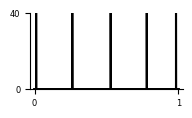

In [11]:
# plot analytic solution compared to simulations with T=1
fig, ax = plt.subplots(1, 1, figsize=figsize_distribution)
axes = [ax]
N = params["N"]

for h in example_hs:
    # simulation data with T=10^4
    x,hist = sim_hist[h][10000]
    # plot histogram as bar plot
    #axes[0].fill_between(x, hist/np.sum(hist)*params["N"], alpha=1, color=window_colors[4])

    # analytic solution (mean-field)
    pmf = np.zeros_like(x)
    a_mf = mean_field_activity(lam_focus, params['mu'], h)
    # find closest x to a_mf
    idx = np.argmin(np.abs(x - a_mf))
    pmf[idx] = 1
    axes[0].plot(x, pmf*params["N"], color='black')

# axes[0].set_xlabel(r"output $\hat{o}$", labelpad=-5)
# axes[0].set_ylabel(r"$p(\hat{o}|h)$")
axes[0].set_xlim(-3*params["sigma"], (1 + 3*params["sigma"]))
axes[0].set_ylim(ylim_distribution)
axes[0].set_xticks(xticks_distribution)
axes[0].set_yticks(yticks_distribution)
# remove top and right spines
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
plt.show()
# save as pdf
fig.savefig("./figures/fig_methods_examples_mean-field.pdf", **kwargs_distribution)

### Distributions from ML Beta solution with $T=10^2$ simulations

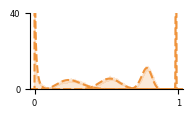

In [23]:
# plot analytic solution compared to simulations with T=1
fig, ax = plt.subplots(1, 1, figsize=figsize_distribution)
axes = [ax]
N = params["N"]

for h in example_hs:
    # simulation data with T=1
    x,hist = sim_hist[h][100]
    # plot histogram as filled area
    axes[0].fill_between(x, hist/np.sum(hist)*params["N"], alpha=0.2, color=window_colors[2], rasterized=True)

    # ML solution
    pmf = ml_pmf(100, lam_focus, h)
    axes[0].plot(ml_support[1:], pmf*params["N"], color=window_colors[2], linestyle='--')

# axes[0].set_xlabel(r"output $\hat{o}$", labelpad=-5)
# axes[0].set_ylabel(r"$p(\hat{o}|h)$")
axes[0].set_xlim(-3*params["sigma"], (1 + 3*params["sigma"]))
axes[0].set_ylim(ylim_distribution)
axes[0].set_xticks(xticks_distribution)
axes[0].set_yticks(yticks_distribution)
# remove top and right spines
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
plt.show()
# save as pdf
fig.savefig("./figures/fig_methods_examples_MLbeta.pdf", **kwargs_distribution)


### Distributions from $T\to 0$ solution with $T=1$ simulations

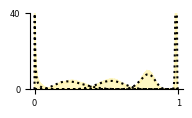

In [26]:
# plot analytic solution compared to simulations with T=1
fig, ax = plt.subplots(1, 1, figsize=figsize_distribution)
axes = [ax]
N = params["N"]

for h in example_hs:
    # simulation data with T=1
    x,hist = sim_hist[h][1]
    # plot histogram as bar plot
    axes[0].fill_between(x, hist/np.sum(hist)*params["N"], alpha=0.7, color=window_colors[0], rasterized=True)

    # analytic solution
    x, pmf = fp_pmf(lam_focus, h)
    x = np.insert(x,0,-1)
    pmf = np.insert(pmf,0,0)
    axes[0].plot(x/params["N"], pmf*params["N"], color='black', linestyle='dotted')

# axes[0].set_xlabel(r"output $\hat{o}$", labelpad=-5)
# axes[0].set_ylabel(r"$p(\hat{o}|h)$")
axes[0].set_xlim(-3*params["sigma"], (1 + 3*params["sigma"]))
axes[0].set_ylim(ylim_distribution)
axes[0].set_xticks(xticks_distribution)
axes[0].set_yticks(yticks_distribution)
# remove top and right spines
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
plt.show()
# save as pdf
fig.savefig("./figures/fig_methods_examples_fokker-planck.pdf", **kwargs_distribution)

## Illustration of Beta approximation 

In [14]:
# load beta fit values from database and compare to neural network approximation
con = sqlite3.connect('./simulations.db')
cur = con.cursor()
simulations = pd.read_sql_query(f"SELECT * FROM simulations WHERE N={params['N']} AND K={params['K']} AND mu={params['mu']} AND seed={params['seed']}", con)
beta_approximations = pd.read_sql_query("SELECT * from beta_approximations", con)
con.close()
df = pd.merge(simulations, beta_approximations, on='simulation_id')
#print(df)

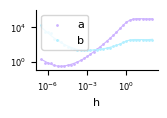

In [34]:
lam_select = [0,0.99,0.9999]
hvals = 10**np.linspace(-6.5, 2, 200)

# different plots for a and b
fig, ax = plt.subplots(1, 1, figsize=figsize_beta, sharex=True, sharey=False)
# for lam in lam_select:
lam = lam_focus
# load data
df_select = df[(df["window"] == win_focus) & (df["lambda"] == lam)]

# get a,b from function approximation
avals, bvals = beta_approx(lam * np.ones_like(hvals), win_focus * np.ones_like(hvals), hvals)

# make smaller markers
ref = ax.scatter(
    df_select["h"].values, df_select["a"], s=1, color="#CDB3FF", label="a"
)
ax.plot(hvals, avals, color=ref.get_facecolor()[0], linestyle="-", linewidth=0.8)

ref = ax.scatter(
    df_select["h"].values, df_select["b"], s=1, color="#B3F0FF", label="b"
)
ax.plot(hvals, bvals, color=ref.get_facecolor()[0], linestyle="-", linewidth=0.8)

# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1e-1,1e6)
ax.set_yticks([1e0, 1e4])
ax.set_xticks([1e-6, 1e-3, 1e0])
ax.set_xlabel("h")
ax.legend()

plt.show()

ax.set_xlabel("")
# unset legend
ax.legend().set_visible(False)

# save as pdf
fig.savefig("./figures/fig_methods_MLapprox.pdf", **kwargs_distribution)

##  Gaussian convolution

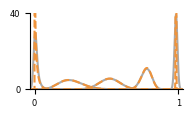

In [16]:
# plot neural network approximation for the selected h values together with the convolution with the normal distribution 
fig, ax = plt.subplots(1, 1, figsize=figsize_distribution)
axes = [ax]
N = params["N"]

for h in example_hs:
    # Gaussian convolution
    pmf = ml_pmf_noisy(window=win_focus, h=h, lam=lam_focus)
    axes[0].plot(ml_support, pmf*params["N"], color='darkgrey')
    
    # network activity
    pmf = ml_pmf(window=win_focus, h=h, lam=lam_focus)
    axes[0].plot(ml_support[1:], pmf*params["N"], linestyle='--', color=window_colors[2])
    
# axes[0].set_xlabel(r"output $\hat{o}$", labelpad=-5)
# axes[0].set_ylabel(r"$p(\hat{o}|h)$")
axes[0].set_xlim(-3*params["sigma"], (1 + 3*params["sigma"]))
axes[0].set_ylim(ylim_distribution)
axes[0].set_xticks(xticks_distribution)
axes[0].set_yticks(yticks_distribution)
# remove top and right spines
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
plt.show()
# save as pdf
if not with_labels:
    axes[0].set_xlabel("")
    axes[0].set_ylabel("")
fig.savefig("./figures/fig_methods_gaussian_convolution.pdf", **kwargs_distribution)

## Discriminable inputs from left and right for ML approach

In [17]:
# check if data set exists in h5 file
with h5py.File(filename, 'r') as f:
    if 'discriminable_inputs' in f:
        print("Loading discriminable inputs from file")
        hs_left = f['discriminable_inputs/hs_left'][()]
        hs_right = f['discriminable_inputs/hs_right'][()]
        pmf_ref_left = f['discriminable_inputs/pmf_ref_left'][()]
        pmf_ref_right = f['discriminable_inputs/pmf_ref_right'][()]
    else:
        hs_left = None
        hs_right = None
    
if hs_left is None and hs_right is None:
    print("Calculating discriminable inputs")
    # calculate discriminable inputs from simulation-constrained h-range
    h_range = beta_approx.input_range[beta_approx.input_names.index("h")]
    
    pmf_ref_left = (
        stats.norm.pdf(
            ml_support, mean_field_activity(lam_focus, params["mu"], 0), params["sigma"]
        )
        / params["N"]
    )
    pmf_ref_right = (
        stats.norm.pdf(
            ml_support, mean_field_activity(lam_focus, params["mu"], 1e3), params["sigma"]
        )
        / params["N"]
    )
    pmf_refs = [pmf_ref_left, pmf_ref_right]
    hs_left = find_discriminable_inputs(
        ml_pmf_, h_range, pmf_refs, params["epsilon"], start="left", verbose=True
    )
    hs_right = find_discriminable_inputs(
        ml_pmf_, h_range, pmf_refs, params["epsilon"], start="right", verbose=True
    )
    # save
    with h5py.File(filename, 'a') as f:
        g = f.create_group('discriminable_inputs')
        g.create_dataset('hs_left', data=hs_left)
        g.create_dataset('hs_right', data=hs_right)
        g.create_dataset('pmf_ref_left', data=pmf_ref_left)
        g.create_dataset('pmf_ref_right', data=pmf_ref_right)



Loading discriminable inputs from file


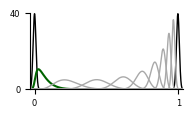

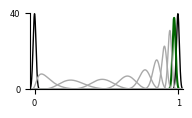

In [40]:
# plot probability distributions p(o|h) for hs_left and hs_right in two plots with reference distributions (integral = sum pmf(x)* \delta x = 1)
for j, hs in enumerate([hs_left, hs_right]):
    fig, ax = plt.subplots(1, 1, figsize=figsize_distribution)
    axes = [ax]
    N = params["N"]

    axes[0].plot(ml_support, pmf_ref_left*params["N"], color="black", linewidth=1)
    axes[0].plot(ml_support, pmf_ref_right*params["N"], color="black", linewidth=1)
    for i, h in enumerate(hs):
        color = "darkgreen" if i == 0 else "darkgray"
        lw = 1.5 if i == 0 else 1
        axes[0].plot(ml_support, ml_pmf_(h)*params["N"], color=color, linewidth=lw)
    # set xlabel to the right of the spline
    # axes[0].set_xlabel(r"output $\hat{o}$", labelpad=-5)
    # axes[0].set_ylabel(r"$p(\hat{o}|h)$")
    axes[0].set_xlim(-3 * params["sigma"], (1 + 3 * params["sigma"]))
    axes[0].set_ylim(ylim_distribution)
    axes[0].set_xticks(xticks_distribution)
    axes[0].set_yticks(yticks_distribution)
    # remove top and right spines
    axes[0].spines["top"].set_visible(False)
    axes[0].spines["right"].set_visible(False)
    plt.show()
    # save as pdf
    if j == 0:
        fig.savefig("./figures/fig_methods_discriminable_left.pdf".format(j), **kwargs_distribution)
    if j == 1:
        fig.savefig("./figures/fig_methods_discriminable_right.pdf".format(j), **kwargs_distribution)